# Training a caption generator
This notebook implements the Show and Tell caption generation model described in our corresponding article. The key portions of this notebook are loading the data with `get_data`, processing the text data with `preProBuildWordVocab`, building the `Caption_Generator` in `train` and tracking our progress.

*Note:* create a directory to save your tensorflow models and assign this directory path to the `model_path` variable.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import math
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import cv2
import skimage
import pickle as pkl


import tensorflow.python.platform
from keras.preprocessing import sequence
from collections import Counter


Using TensorFlow backend.


In [2]:
#import notebook_util
#notebook_util.pick_gpu_lowest_memory()
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3467749318751539807, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 4115159378514944373
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:89:00.0, compute capability: 6.1", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 15350134118348698475
 physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:8a:00.0, compute capability: 6.1"]

# Downloading Data
As mentioned in the README, in order to run this notebook, you will need VGG-16 image embeddings for the Flickr-30K dataset. These image embeddings are available from our [Google Drive](https://drive.google.com/file/d/0B5o40yxdA9PqTnJuWGVkcFlqcG8/view?usp=sharing).

Additionally, you will need the corresponding captions for these images (`results_20130124.token`), which can also be downloaded from our [Google Drive](https://drive.google.com/file/d/0B2vTU3h54lTydXFjSVM5T2t4WmM/view?usp=sharing).

Place all of these downloads in the `./data/` folder.

The feature embeddings will be in `./data/feats.npy` and the embeddings' corresponding captions will be saved to `./data/results_20130124.token` .

In [3]:
model_path = './models/tensorflow'
model_path_transfer = './models/tf_final'
feature_path = './data/feats.npy'
annotation_path = './data/results_20130124.token'
flickr_30k_path = "./data/flickr30k/flickr30k_images"

## Loading data
Parse the image embedding features from the Flickr30k dataset `./data/feats.npy`, and load the caption data via `pandas` from `./data/results_20130124.token`

In [4]:
# read in the embeddings
def get_data(annotation_path, feature_path): 
     annotations = pd.read_table(annotation_path, sep='\t', header=None, names=['image', 'caption'])
     return np.load(feature_path,'r'), annotations['caption'].values,  [s[:-2] for s in annotations['image'].values]

In [5]:
feats, captions, images = get_data(annotation_path, feature_path)

In [18]:
#print(feats.shape) # 4096 dimensional image embedding for each image
#print(captions.shape)
assert feats.shape[0] == captions.shape[0]
feats.shape

(158915, 4096)

Chosen image 136558.
A man attempts to get a ball through a hoop as a bystander watches at a park .


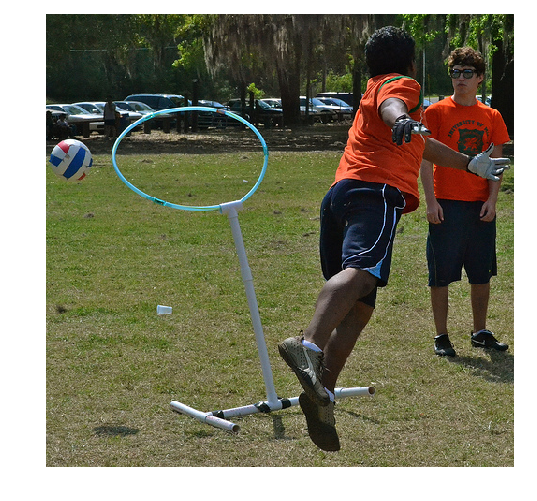

./data/flickr30k/flickr30k_images/5611391594.jpg


In [7]:
#plt.imshow(feats[0].reshape(64,64) )
#plt.show()
#cv2.imshow('test',feats[0].reshape(64,64))

def show_image(image_path):
    # load the image, convert it to grayscale, and show it
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.figure(figsize=(8,6), dpi=100)
    plt.axis('off')
    plt.imshow(cv2.cvtColor( np.squeeze(img), cv2.COLOR_BGR2RGB))
    plt.show()
    
rnd = np.random.randint(0, len(captions)-1)
print('Chosen image {}.'.format(rnd))
print(captions[rnd])
img_path = os.path.join(flickr_30k_path, images[rnd])
show_image(img_path)
print(img_path)

In [8]:
def preProBuildWordVocab(sentence_iterator, word_count_threshold=30):
    # function from Andre Karpathy's NeuralTalk
    print('preprocessing %d word vocab' % (word_count_threshold, ))
    word_counts = {}
    nsents = 0
    for sent in sentence_iterator:
      nsents += 1
      for w in sent.lower().split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

    # create mappings for the words-indices
    ixtoword = {}
    ixtoword[0] = '.'  
    wordtoix = {}
    wordtoix['#START#'] = 0 
    ix = 1
    for w in vocab:
      wordtoix[w] = ix
      ixtoword[ix] = w
      ix += 1

    word_counts['.'] = nsents
    bias_init_vector = np.array([1.0*word_counts[ixtoword[i]] for i in ixtoword])
    bias_init_vector /= np.sum(bias_init_vector) 
    bias_init_vector = np.log(bias_init_vector)
    bias_init_vector -= np.max(bias_init_vector) 
    
    return wordtoix, ixtoword, bias_init_vector.astype(np.float32)

In [9]:
class Caption_Generator():
    def __init__(self, dim_in, dim_embed, dim_hidden, batch_size, n_lstm_steps, n_words, init_b):

        self.dim_in = dim_in        # input dimension
        self.dim_embed = dim_embed  # embeddings dimension
        self.dim_hidden = dim_hidden # hidden layer dimensions
        self.batch_size = batch_size
        self.n_lstm_steps = n_lstm_steps
        self.n_words = n_words
        
        # declare the variables to be used for our word embeddings
        with tf.device("/cpu:0"):
            self.word_embedding = tf.Variable(tf.random_uniform([self.n_words, self.dim_embed], -0.1, 0.1), name='word_embedding')

        self.embedding_bias = tf.Variable(tf.zeros([dim_embed]), name='embedding_bias')
        
        # declare the LSTM itself
        self.lstm = tf.contrib.rnn.BasicLSTMCell(dim_hidden)
        
        # declare the variables to be used to embed the image feature embedding to the word embedding space
        self.img_embedding = tf.Variable(tf.random_uniform([dim_in, dim_hidden], -0.1, 0.1), name='img_embedding')
        self.img_embedding_bias = tf.Variable(tf.zeros([dim_hidden]), name='img_embedding_bias')

        # declare the variables to go from an LSTM output to a word encoding output
        self.word_encoding = tf.Variable(tf.random_uniform([dim_hidden, n_words], -0.1, 0.1), name='word_encoding')
        # initialize this bias variable from the preProBuildWordVocab output
        self.word_encoding_bias = tf.Variable(init_b, name='word_encoding_bias')

    def build_model(self):
        # declaring the placeholders for our extracted image feature vectors, our caption, and our mask
        # (describes how long our caption is with an array of 0/1 values of length `maxlen`  
        img = tf.placeholder(tf.float32, [self.batch_size, self.dim_in])
        caption_placeholder = tf.placeholder(tf.int32, [self.batch_size, self.n_lstm_steps])
        mask = tf.placeholder(tf.float32, [self.batch_size, self.n_lstm_steps]) 
        
        # getting an initial LSTM embedding from our image_imbedding
        image_embedding = tf.matmul(img, self.img_embedding) + self.img_embedding_bias
        
        # setting initial state of our LSTM
        state = self.lstm.zero_state(self.batch_size, dtype=tf.float32)

        total_loss = 0.0
        with tf.variable_scope("RNN"):
            for i in range(self.n_lstm_steps): 
                if i > 0:
                   #if this isn’t the first iteration of our LSTM we need to get the word_embedding corresponding
                   # to the (i-1)th word in our caption 
                    with tf.device("/cpu:0"):
                        current_embedding = tf.nn.embedding_lookup(self.word_embedding, caption_placeholder[:,i-1]) + self.embedding_bias
                else:
                     #if this is the first iteration of our LSTM we utilize the embedded image as our input 
                    current_embedding = image_embedding
                if i > 0: 
                    # allows us to reuse the LSTM tensor variable on each iteration
                    tf.get_variable_scope().reuse_variables()

                out, state = self.lstm(current_embedding, state)

                if i > 0:
                    #get the one-hot representation of the next word in our caption 
                    labels = tf.expand_dims(caption_placeholder[:, i], 1)
                    ix_range=tf.range(0, self.batch_size, 1)
                    ixs = tf.expand_dims(ix_range, 1)
                    concat = tf.concat([ixs, labels],1)
                    onehot = tf.sparse_to_dense(
                            concat, tf.stack([self.batch_size, self.n_words]), 1.0, 0.0)


                    #perform a softmax classification to generate the next word in the caption
                    logit = tf.matmul(out, self.word_encoding) + self.word_encoding_bias
                    xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=logit, labels=onehot)
                    xentropy = xentropy * mask[:,i]

                    loss = tf.reduce_sum(xentropy)
                    total_loss += loss

            total_loss = total_loss / tf.reduce_sum(mask[:,1:])
            return total_loss, img, caption_placeholder, mask


In [10]:
### Parameters ###
dim_embed = 256
dim_hidden = 256
dim_in = 4096
batch_size = 128
momentum = 0.9
n_epochs =  1000 #150

def train(learning_rate=0.001, continue_training=False, transfer=True):
    losses = []
    itr, last_epoch = 0, 0
    
    tf.reset_default_graph()

    feats, captions, image_names = get_data(annotation_path, feature_path)
    # preprocess and build word vocabulary
    wordtoix, ixtoword, init_b = preProBuildWordVocab(captions)
    np.save('data/ixtoword', ixtoword) # store the index to word mappings

    index = (np.arange(len(feats)).astype(int))
    np.random.shuffle(index)

    sess = tf.InteractiveSession()
    
    n_words = len(wordtoix)
    maxlen = np.max( [x for x in map(lambda x: len(x.split(' ')), captions) ] ) # maximum length of a caption in # words
    
    caption_generator = Caption_Generator(dim_in, dim_hidden, dim_embed, batch_size, maxlen+2, n_words, init_b)
    loss, image, sentence, mask = caption_generator.build_model()

    # TF saver
    saver = tf.train.Saver(max_to_keep=100)
    global_step=tf.Variable(0,trainable=False)
    
    # exponential decay learning rate
    learning_rate = tf.train.exponential_decay(learning_rate, global_step, int(len(index)/batch_size), 0.95)
    # ADAM
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    
    tf.global_variables_initializer().run()

    # CONTINUE TRAINING / LOAD CHECKPOINTS
    if continue_training:
        if not transfer: #  from previously saved weights
            saver.restore(sess, tf.train.latest_checkpoint(model_path))
            if os.path.exists( os.getcwd() + '/losses.npy'):
                losses = list(np.load('losses.npy'))
                itr = len(losses)
                last_epoch = int(itr / batch_size)
                print('Loaded previous checkpoint from {}. Epoch {}, iteration: {}'.format( model_path, last_epoch, itr))
            else:
                print("No previously stored losses file.")
        else:
            saver.restore(sess,tf.train.latest_checkpoint(model_path_transfer))
    
    for epoch in range(last_epoch, n_epochs + last_epoch):
        for start, end in zip( range(0, len(index), batch_size), range(batch_size, len(index), batch_size)):

            current_feats = feats[index[start:end]]
            current_captions = captions[index[start:end]]
            current_caption_ind = [x for x in map(lambda cap: [wordtoix[word] for word in cap.lower().split(' ')[:-1] if word in wordtoix], current_captions)]

            current_caption_matrix = sequence.pad_sequences(current_caption_ind, padding='post', maxlen=maxlen+1)
            current_caption_matrix = np.hstack( [np.full( (len(current_caption_matrix),1), 0), current_caption_matrix] )

            current_mask_matrix = np.zeros((current_caption_matrix.shape[0], current_caption_matrix.shape[1]))
            nonzeros = np.array([x for x in map(lambda x: (x != 0).sum()+2, current_caption_matrix )])

            for ind, row in enumerate(current_mask_matrix):
                row[:nonzeros[ind]] = 1

            _, loss_value = sess.run([train_op, loss], feed_dict={
                                                                    image:     current_feats.astype(np.float32),
                                                                    sentence : current_caption_matrix.astype(np.int32),
                                                                    mask :     current_mask_matrix.astype(np.float32)
                                                                  })
            
            losses.append(loss_value)
            
            if itr % 100 == 0:
                print("Iteration {}".format(itr))
                print("Current Cost: ", loss_value, "\t Epoch {}/{}".format(epoch, n_epochs + last_epoch), "\t Iter {}/{}".format(start,len(feats)))
            itr += 1
            
        print("Saving the model from epoch: ", epoch)
        saver.save(sess, os.path.join(model_path, 'model'), global_step=epoch)
        np.save('losses.npy', losses)
        
    sess.close()

In [12]:
try:
    #train(.001,False,False)  #train from scratch
    #train(.001,True,True)    #continue training from pretrained weights @epoch500
    train(.001,True,False)    #train from previously saved weights 
except KeyboardInterrupt:
    print('Exiting Training')

preprocessing 30 word vocab
preprocessed words 20326 -> 2942
INFO:tensorflow:Restoring parameters from ./models/tensorflow/model-1596
Loaded previous checkpoint from ./models/tensorflow. Epoch 1745, iteration: 223380
Iteration 223400
('Current Cost: ', 1.8400748, '\t Epoch 1745/2745', '\t Iter 2560/158915')
Iteration 223500
('Current Cost: ', 1.8405889, '\t Epoch 1745/2745', '\t Iter 15360/158915')
Iteration 223600
('Current Cost: ', 1.830073, '\t Epoch 1745/2745', '\t Iter 28160/158915')
Iteration 223700
('Current Cost: ', 2.0064499, '\t Epoch 1745/2745', '\t Iter 40960/158915')
Iteration 223800
('Current Cost: ', 1.8595109, '\t Epoch 1745/2745', '\t Iter 53760/158915')
Iteration 223900
('Current Cost: ', 1.8984025, '\t Epoch 1745/2745', '\t Iter 66560/158915')
Iteration 224000
('Current Cost: ', 1.9160203, '\t Epoch 1745/2745', '\t Iter 79360/158915')
Iteration 224100
('Current Cost: ', 2.0057375, '\t Epoch 1745/2745', '\t Iter 92160/158915')
Iteration 224200
('Current Cost: ', 2.021

Iteration 231700
('Current Cost: ', 1.8978198, '\t Epoch 1751/2745', '\t Iter 111872/158915')
Iteration 231800
('Current Cost: ', 2.0209649, '\t Epoch 1751/2745', '\t Iter 124672/158915')
Iteration 231900
('Current Cost: ', 1.9852536, '\t Epoch 1751/2745', '\t Iter 137472/158915')
Iteration 232000
('Current Cost: ', 1.9701378, '\t Epoch 1751/2745', '\t Iter 150272/158915')
('Saving the model from epoch: ', 1751)
Iteration 232100
('Current Cost: ', 1.9668831, '\t Epoch 1752/2745', '\t Iter 4224/158915')
Iteration 232200
('Current Cost: ', 1.940662, '\t Epoch 1752/2745', '\t Iter 17024/158915')
Iteration 232300
('Current Cost: ', 2.0002608, '\t Epoch 1752/2745', '\t Iter 29824/158915')
Iteration 232400
('Current Cost: ', 1.9717994, '\t Epoch 1752/2745', '\t Iter 42624/158915')
Iteration 232500
('Current Cost: ', 1.9278567, '\t Epoch 1752/2745', '\t Iter 55424/158915')
Iteration 232600
('Current Cost: ', 1.9505001, '\t Epoch 1752/2745', '\t Iter 68224/158915')
Iteration 232700
('Current C

Iteration 240200
('Current Cost: ', 1.9295088, '\t Epoch 1758/2745', '\t Iter 87936/158915')
Iteration 240300
('Current Cost: ', 1.9065225, '\t Epoch 1758/2745', '\t Iter 100736/158915')
Iteration 240400
('Current Cost: ', 1.8840445, '\t Epoch 1758/2745', '\t Iter 113536/158915')
Iteration 240500
('Current Cost: ', 1.9340107, '\t Epoch 1758/2745', '\t Iter 126336/158915')
Iteration 240600
('Current Cost: ', 1.9572754, '\t Epoch 1758/2745', '\t Iter 139136/158915')
Iteration 240700
('Current Cost: ', 1.9008018, '\t Epoch 1758/2745', '\t Iter 151936/158915')
('Saving the model from epoch: ', 1758)
Iteration 240800
('Current Cost: ', 1.8530086, '\t Epoch 1759/2745', '\t Iter 5888/158915')
Iteration 240900
('Current Cost: ', 1.9054056, '\t Epoch 1759/2745', '\t Iter 18688/158915')
Iteration 241000
('Current Cost: ', 1.9199071, '\t Epoch 1759/2745', '\t Iter 31488/158915')
Iteration 241100
('Current Cost: ', 1.9176922, '\t Epoch 1759/2745', '\t Iter 44288/158915')
Iteration 241200
('Current

Iteration 248700
('Current Cost: ', 1.8642535, '\t Epoch 1765/2745', '\t Iter 64000/158915')
Iteration 248800
('Current Cost: ', 1.9102683, '\t Epoch 1765/2745', '\t Iter 76800/158915')
Iteration 248900
('Current Cost: ', 1.9638377, '\t Epoch 1765/2745', '\t Iter 89600/158915')
Iteration 249000
('Current Cost: ', 1.9526713, '\t Epoch 1765/2745', '\t Iter 102400/158915')
Iteration 249100
('Current Cost: ', 1.849534, '\t Epoch 1765/2745', '\t Iter 115200/158915')
Iteration 249200
('Current Cost: ', 1.9807004, '\t Epoch 1765/2745', '\t Iter 128000/158915')
Iteration 249300
('Current Cost: ', 1.9840236, '\t Epoch 1765/2745', '\t Iter 140800/158915')
Iteration 249400
('Current Cost: ', 2.0231645, '\t Epoch 1765/2745', '\t Iter 153600/158915')
('Saving the model from epoch: ', 1765)
Iteration 249500
('Current Cost: ', 1.9900193, '\t Epoch 1766/2745', '\t Iter 7552/158915')
Iteration 249600
('Current Cost: ', 1.9278558, '\t Epoch 1766/2745', '\t Iter 20352/158915')
Iteration 249700
('Current 

Iteration 257200
('Current Cost: ', 1.8916897, '\t Epoch 1772/2745', '\t Iter 40064/158915')
Iteration 257300
('Current Cost: ', 1.9558977, '\t Epoch 1772/2745', '\t Iter 52864/158915')
Iteration 257400
('Current Cost: ', 1.9430672, '\t Epoch 1772/2745', '\t Iter 65664/158915')
Iteration 257500
('Current Cost: ', 1.9790622, '\t Epoch 1772/2745', '\t Iter 78464/158915')
Iteration 257600
('Current Cost: ', 1.9228073, '\t Epoch 1772/2745', '\t Iter 91264/158915')
Iteration 257700
('Current Cost: ', 1.964852, '\t Epoch 1772/2745', '\t Iter 104064/158915')
Iteration 257800
('Current Cost: ', 1.9490095, '\t Epoch 1772/2745', '\t Iter 116864/158915')
Iteration 257900
('Current Cost: ', 1.9234247, '\t Epoch 1772/2745', '\t Iter 129664/158915')
Iteration 258000
('Current Cost: ', 1.9478065, '\t Epoch 1772/2745', '\t Iter 142464/158915')
Iteration 258100
('Current Cost: ', 1.9858049, '\t Epoch 1772/2745', '\t Iter 155264/158915')
('Saving the model from epoch: ', 1772)
Iteration 258200
('Current

Iteration 265700
('Current Cost: ', 1.8568708, '\t Epoch 1779/2745', '\t Iter 16128/158915')
Iteration 265800
('Current Cost: ', 1.9328791, '\t Epoch 1779/2745', '\t Iter 28928/158915')
Iteration 265900
('Current Cost: ', 1.9507806, '\t Epoch 1779/2745', '\t Iter 41728/158915')
Iteration 266000
('Current Cost: ', 2.0532863, '\t Epoch 1779/2745', '\t Iter 54528/158915')
Iteration 266100
('Current Cost: ', 1.8928933, '\t Epoch 1779/2745', '\t Iter 67328/158915')
Iteration 266200
('Current Cost: ', 1.9790753, '\t Epoch 1779/2745', '\t Iter 80128/158915')
Iteration 266300
('Current Cost: ', 1.9190048, '\t Epoch 1779/2745', '\t Iter 92928/158915')
Iteration 266400
('Current Cost: ', 1.9300513, '\t Epoch 1779/2745', '\t Iter 105728/158915')
Iteration 266500
('Current Cost: ', 2.0114741, '\t Epoch 1779/2745', '\t Iter 118528/158915')
Iteration 266600
('Current Cost: ', 1.9112905, '\t Epoch 1779/2745', '\t Iter 131328/158915')
Iteration 266700
('Current Cost: ', 1.8705724, '\t Epoch 1779/2745'

('Saving the model from epoch: ', 1785)
Iteration 274300
('Current Cost: ', 1.9833471, '\t Epoch 1786/2745', '\t Iter 4992/158915')
Iteration 274400
('Current Cost: ', 1.9496554, '\t Epoch 1786/2745', '\t Iter 17792/158915')
Iteration 274500
('Current Cost: ', 2.0563943, '\t Epoch 1786/2745', '\t Iter 30592/158915')
Iteration 274600
('Current Cost: ', 1.9037358, '\t Epoch 1786/2745', '\t Iter 43392/158915')
Iteration 274700
('Current Cost: ', 1.945315, '\t Epoch 1786/2745', '\t Iter 56192/158915')
Iteration 274800
('Current Cost: ', 1.8909364, '\t Epoch 1786/2745', '\t Iter 68992/158915')
Iteration 274900
('Current Cost: ', 1.8954389, '\t Epoch 1786/2745', '\t Iter 81792/158915')
Iteration 275000
('Current Cost: ', 1.9015377, '\t Epoch 1786/2745', '\t Iter 94592/158915')
Iteration 275100
('Current Cost: ', 1.8559203, '\t Epoch 1786/2745', '\t Iter 107392/158915')
Iteration 275200
('Current Cost: ', 1.8632033, '\t Epoch 1786/2745', '\t Iter 120192/158915')
Iteration 275300
('Current Cos

Previous checkpoint from ./models/tensorflow, Epochs 2153, iterations: 275584


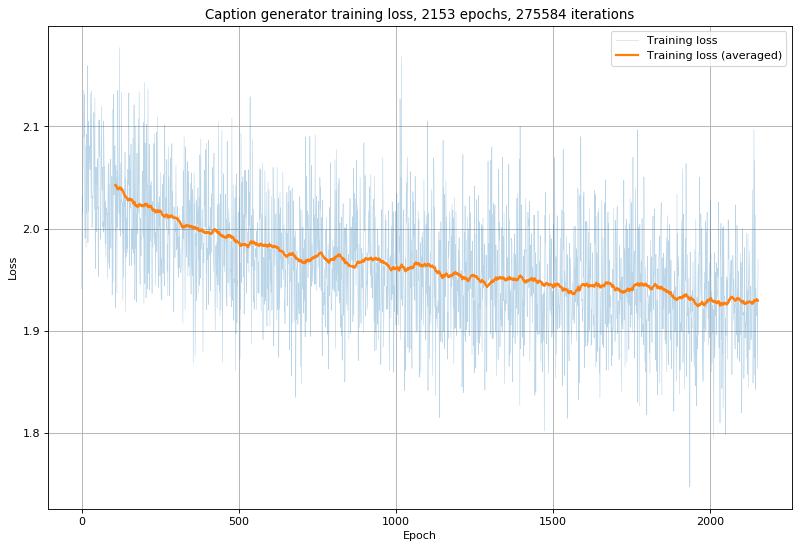

In [16]:

%matplotlib inline
fig = plt.figure(figsize=(12,8), dpi=80)
losses = np.load('losses.npy')[0::batch_size]
filter_size = math.floor(losses.shape[0]/( 20.) )
losses_c = np.convolve(losses, [1/filter_size]*int(filter_size) )
losses_c2 = np.convolve(losses, [1/filter_size]*int(filter_size) )

last_epoch = len(losses)
itr = last_epoch*batch_size
# not test batch_size (=1)

print('Previous checkpoint from {}, Epochs {}, iterations: {}'.format( model_path, last_epoch , itr))

plt.plot(range( len(losses)) ,
         losses, 
         '-', markersize=1, linewidth=0.5, alpha=0.3, label='Training loss')
plt.plot(range(int(filter_size),len(losses_c)-int(filter_size)),  
         losses_c[int(filter_size):-int(filter_size)],
         '-', linewidth=2, label='Training loss (averaged)')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Caption generator training loss, {} epochs, {} iterations'.format(last_epoch,itr))
plt.legend()
plt.show()

fig.savefig("Training_loss_epoch_{}.png".format(last_epoch))